In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tools import load_nyt_database, get_psycinfo_database, word_freq
import itertools
from matplotlib.ticker import ScalarFormatter, LogFormatter, LogFormatterExponent, LogFormatterMathtext

In [2]:
%matplotlib inline

In [3]:
nyt = load_nyt_database()
psyc = get_psycinfo_database()

In [78]:
def plot_both(words, norm=True):
    df1 = word_freq(words)
    y = df1
    if norm:
     y = y/ y.mean()
    axis_1 = y.plot(figsize=(24,6))
    axis_1.set_ylabel("Google Book Ngrams ($\%$)")
    axis_1.set_xlabel("Year")
    _ = axis_1.legend(loc='upper left', ncol=2)
    axis_1.set_yscale('log') # You can disable
    if norm:
      axis_1.set_ylim(1e-2, 1e2) # You can disable
    axis_1.yaxis.set_major_formatter(LogFormatterMathtext())     
    axis_1.grid(True)
    axis_1.set_xlim(1800, 2000)

    y = pd.rolling_mean(nyt[words], 10)
    if norm:
     y = y/ y.mean()
    axis_2 = y.plot(figsize=(24,6))
    axis_2.set_ylabel("New York Times ($\%$)")
    axis_2.set_yscale('log') # You can disable
    if norm:
      axis_2.set_ylim(1e-2, 1e2) # You can disable
    else:
      axis_2.set_ylim(ymin=1e-7) # You can disable        
    axis_2.yaxis.set_major_formatter(LogFormatterMathtext())
    axis_2.grid(True)
    axis_2.set_xlim(1800, 2000)
    _ = axis_2.legend(loc='upper left', ncol=2)

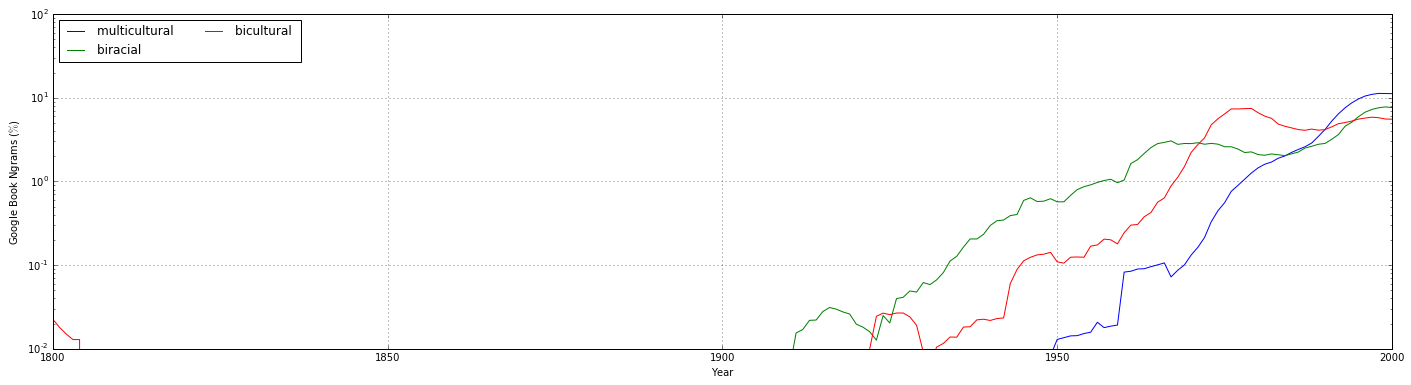

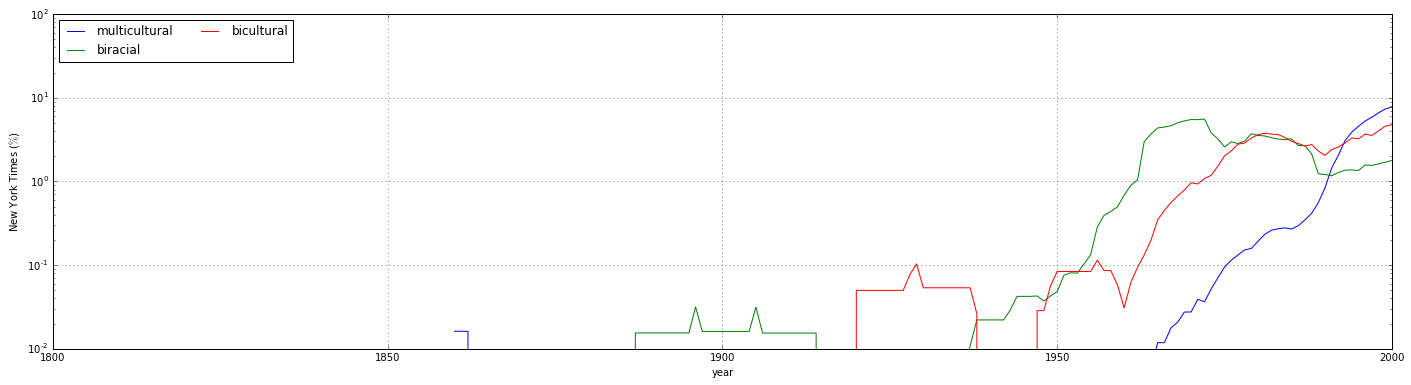

In [79]:
words = ["multicultural", "biracial", "bicultural"]

plot_both(words)

In [84]:
words_to_replace = {"/":"-", "bi-ethnic": "biethnic", "bi-racial": "biracial", 
                    "mono-ethnic": "monoethnic", "poly-ethnic": "polyethnic", 
                    "mono-racial": "monoracial", "multi-racial": "multiracial",
                    "inter-racial": "interracial", "mono-cultural": "monocultural",
                    "bi-cultural": "bicultural", "multi-cultural": "multicultural",
                    "other ethnicity":"other-ethnicity", "other race": "other-race", 
                    "mixed race": "mixed-race", "mixed ethnicity": "mixed-ethnicity"}

In [87]:
psyc.Date

0      2010
1      2010
2      2010
3      2010
4      2010
5      2010
6      2010
7      2010
8      2010
9      2010
10     2010
11     2010
12     2010
13     2010
14     2010
15     2010
16     2010
17     2010
18     2010
19     2010
20     2010
21     2010
22     2010
23     2010
24     2010
25     2010
26     2010
27     2010
28     2010
29     2010
       ... 
970    2003
971    2003
972    2003
973    2003
974    2003
975    2003
976    2003
977    2003
978    2003
979    2003
980    2003
981    2003
982    2003
983    2003
984    2003
985    2003
986    2003
987    2003
988    2003
989    2003
990    2003
991    2003
992    2003
993    2003
994    2003
995    2003
996    2003
997    2003
998    2003
999    2003
Name: Date, dtype: object